<div style="display: flex; align-items: center;">
    <img src="https://github.com/nagelt/Teaching_Scripts/raw/9d9e29ecca4b04eaf7397938eacbf116d37ddc93/Images/TUBAF_Logo_blau.png" width="500" height="auto" height="auto" style="margin-right: 100px;" />
    <div>
        <p><strong>Prof. Dr. Thomas Nagel</strong></p>
        <p>Chair of Soil Mechanics and Foundation Engineering<br>Geotechnical Institute<br>Technische Universität Bergakademie Freiberg.</p>
        <p><a href="https://tu-freiberg.de/en/soilmechanics">https://tu-freiberg.de/en/soilmechanics</a></p>
    </div>
</div>

# A finite element code written by ChatGPT

This code was written with the help of ChatGPT. Some guiding was required and the code makes some strong assumptions, but one obtains a base code remarkably fast, that can now be tested.

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.sparse import lil_matrix
from scipy.sparse.linalg import spsolve

In [2]:
# Material properties
E = 200e6   # Young's modulus (Pa)
nu = 0.3    # Poisson's ratio

# Domain dimensions
L = 100.0    # Length (m)
H = 20.0     # Height (m)
nx = 100     # Number of elements along x
ny = 20     # Number of elements along y

# Derived properties
D = E / (1 - nu**2) * np.array([[1, nu, 0], [nu, 1, 0], [0, 0, (1 - nu) / 2]])
print(D)

[[2.19780220e+08 6.59340659e+07 0.00000000e+00]
 [6.59340659e+07 2.19780220e+08 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 7.69230769e+07]]


In [3]:
# Mesh generation
def generate_mesh(L, H, nx, ny):
    x = np.linspace(0, L, nx+1)
    y = np.linspace(0, H, ny+1)
    nodes = np.array([[xi, yi] for yi in y for xi in x])
    elements = []
    for j in range(ny):
        for i in range(nx):
            n1 = j*(nx+1) + i
            n2 = n1 + 1
            n3 = n1 + (nx+1)
            n4 = n3 + 1
            elements.append([n1, n2, n4, n3])
    return nodes, np.array(elements)

In [4]:
# Quadrilateral shape functions
def shape_functions(xi, eta):
    N1 = (1 - xi)*(1 - eta)/4
    N2 = (1 + xi)*(1 - eta)/4
    N3 = (1 + xi)*(1 + eta)/4
    N4 = (1 - xi)*(1 + eta)/4
    return np.array([N1, N2, N3, N4])

In [5]:
# B matrix calculation
def B_matrix(xi, eta, coords):
    Nxi = np.array([[-(1 - eta), (1 - eta), (1 + eta), -(1 + eta)]]) / 4
    Neta = np.array([[-(1 - xi), -(1 + xi), (1 + xi), (1 - xi)]]) / 4
    J = np.dot(np.vstack((Nxi, Neta)), coords)  # Jacobian matrix
    invJ = np.linalg.inv(J)
    dN = np.dot(invJ, np.vstack((Nxi, Neta)))
    B = np.zeros((3, 8))
    B[0, 0::2] = dN[0, :]
    B[1, 1::2] = dN[1, :]
    B[2, 0::2] = dN[1, :]
    B[2, 1::2] = dN[0, :]
    return B, np.linalg.det(J)

In [6]:
# Finite element assembly
def assemble_system(nodes, elements, D):
    num_nodes = len(nodes)
    K = np.zeros((2*num_nodes, 2*num_nodes))
    F = np.zeros(2*num_nodes)

    # Gauss points and weights for 2x2 quadrature
    gauss_points = [(-1/np.sqrt(3), -1/np.sqrt(3)), (1/np.sqrt(3), -1/np.sqrt(3)),
                    (1/np.sqrt(3), 1/np.sqrt(3)), (-1/np.sqrt(3), 1/np.sqrt(3))]
    
    for element in elements:
        coords = nodes[element]
        Ke = np.zeros((8, 8))
        
        for xi, eta in gauss_points:
            B, detJ = B_matrix(xi, eta, coords)
            Ke += np.dot(B.T, np.dot(D, B)) * detJ * 1
        
        # Assembly into global matrix
        for i in range(4):
            for j in range(4):
                K[2*element[i]:2*element[i]+2, 2*element[j]:2*element[j]+2] += Ke[2*i:2*i+2, 2*j:2*j+2]
    
    # Apply surface load on top boundary
    top_nodes = np.where(nodes[:, 1] == H)[0]
    for node in top_nodes:
        F[2*node+1] = -1e5  # Apply downward load
    
    return K, F

In [7]:
def apply_boundary_conditions(K, F, nodes, L, H, traction_intensity=2e5, traction_width=10.0):
    # Get the nodes on the bottom boundary (y=0) to fix in y-direction
    bottom_nodes = np.where(nodes[:, 1] == 0)[0]
    
    # Get the nodes on the left boundary (x=0) and right boundary (x=L) to fix in x-direction
    left_nodes = np.where(nodes[:, 0] == 0)[0]
    right_nodes = np.where(nodes[:, 0] == L)[0]

    # Fix the y-displacement of the bottom nodes
    fixed_dofs = []
    for node in bottom_nodes:
        fixed_dofs.append(2*node + 1)  # Fix y displacement (U_y)
    
    # Fix the x-displacement of the left and right boundary nodes
    for node in np.concatenate([left_nodes, right_nodes]):
        fixed_dofs.append(2*node)  # Fix x displacement (U_x)
    
    # Apply a point load at one-quarter of the top boundary (y=H, x=L/4)
    top_nodes = np.where(nodes[:, 1] == H)[0]
    quarter_top_node = top_nodes[np.argmin(np.abs(nodes[top_nodes, 0] - L/4))]
    
    # Apply a downward point load at L/4 on the top boundary
    F[2*quarter_top_node + 1] = -1e6  # Apply load in y-direction (negative for downward load)
    
    # Apply a rectangular traction centered at 3L/4 with width = traction_width
    # Traction is applied in the y-direction
    center_x = 3*L / 4
    traction_nodes = top_nodes[(nodes[top_nodes, 0] >= center_x - traction_width / 2) & 
                               (nodes[top_nodes, 0] <= center_x + traction_width / 2)]
    
    # Total traction force to apply (intensity * width), evenly distribute over the traction nodes
    traction_force = traction_intensity * traction_width
    traction_per_node = traction_force / len(traction_nodes)
    
    for node in traction_nodes:
        F[2*node + 1] += -traction_per_node  # Apply downward traction force to each node in y-direction
    
    # Get the degrees of freedom that are not fixed
    free_dofs = np.setdiff1d(np.arange(K.shape[0]), fixed_dofs)
    
    # Eliminate fixed DOFs
    K_ff = K[free_dofs, :][:, free_dofs]
    F_f = F[free_dofs]
    
    return K_ff, F_f, free_dofs


In [8]:
# Solve system
def solve_elasticity(K, F, free_dofs, num_dofs):
    U = np.zeros(num_dofs)
    U_f = spsolve(K, F)
    U[free_dofs] = U_f
    return U

In [9]:
def plot_displacements(nodes, elements, U, scale=100):
    plt.figure(figsize=(12, 8))
    
    for element in elements:
        # Extract the node coordinates for the element
        x = nodes[element, 0]
        y = nodes[element, 1]
        
        # Extract the displacements for the element's nodes
        u_x = U[2*element]   # X displacements of the 4 nodes
        u_y = U[2*element+1] # Y displacements of the 4 nodes
        
        # Plot the original element
        plt.plot(x, y, 'b-', alpha=0.3, lw=1)  # Original configuration
        
        # Plot the displaced element (scaled for visualization)
        plt.plot(x + scale * u_x, y + scale * u_y, 'r-',lw=1)  # Deformed configuration
    
    plt.title(r'Displacements (scaled)')
    plt.xlabel(r'X [m]')
    plt.ylabel(r'Y [m]')
    plt.gca().set_aspect('equal', adjustable='box')
    plt.legend(['Original', 'Deformed'])
    plt.show()

In [10]:
nodes, elements = generate_mesh(L, H, nx, ny)

In [11]:
K, F = assemble_system(nodes, elements, D)

In [12]:
K_ff, F_f, free_dofs = apply_boundary_conditions(K, F, nodes, L, H)

In [13]:
U = solve_elasticity(K_ff, F_f, free_dofs, len(F))

/opt/anaconda3/lib/python3.10/site-packages/scipy/sparse/linalg/_dsolve/linsolve.py:214: SparseEfficiencyWarning: spsolve requires A be CSC or CSR matrix format
  warn('spsolve requires A be CSC or CSR matrix format',


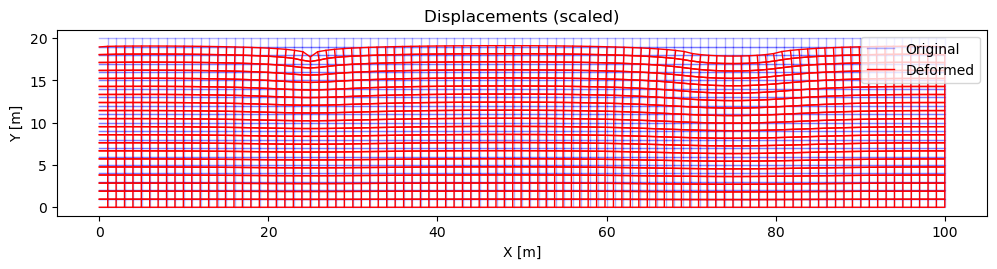

In [14]:
plot_displacements(nodes, elements, U)

In [15]:
def convert_quads_to_tris(elements):
    """
    Convert each quadrilateral element into two triangular elements.
    """
    triangles = []
    for quad in elements:
        # Split the quadrilateral into two triangles
        triangles.append([quad[0], quad[1], quad[2]])  # Triangle 1
        triangles.append([quad[0], quad[2], quad[3]])  # Triangle 2
    return np.array(triangles)

In [16]:
def compute_element_stresses(nodes, elements, U, D):
    stresses = []
    
    gauss_points = [(-1/np.sqrt(3), -1/np.sqrt(3)), (1/np.sqrt(3), -1/np.sqrt(3)),
                    (1/np.sqrt(3), 1/np.sqrt(3)), (-1/np.sqrt(3), 1/np.sqrt(3))]
    
    for element in elements:
        coords = nodes[element]
        element_stresses = []
        
        # Loop over the Gauss points
        for xi, eta in gauss_points:
            B, detJ = B_matrix(xi, eta, coords)
            
            # Get the displacement for the nodes of the element
            Ue = np.zeros(8)
            for i in range(4):
                Ue[2*i] = U[2*element[i]]     # U_x component
                Ue[2*i+1] = U[2*element[i]+1] # U_y component
            
            # Compute the strain at this Gauss point
            strain = np.dot(B, Ue)
            
            # Compute stress using Hooke's law (stress = D * strain)
            stress = np.dot(D, strain)
            element_stresses.append(stress)
        
        # Average stress over the Gauss points
        avg_stress = np.mean(element_stresses, axis=0)
        stresses.append(avg_stress)
    
    return np.array(stresses)

In [17]:
def compute_von_mises_stress(stresses):
    von_mises_stress = np.sqrt(((stresses[:, 0] - stresses[:, 1])**2 + stresses[:, 0]**2 + stresses[:, 1]**2 + 6*stresses[:, 2]**2) / 2)
    return von_mises_stress

In [18]:
def plot_stress_distribution(nodes, elements, von_mises_stress):
    # Convert quadrilateral elements into triangles
    triangles = convert_quads_to_tris(elements)
    
    # Repeat von Mises stress for each of the two triangles that came from the same quadrilateral
    repeated_von_mises_stress = np.repeat(von_mises_stress, 2)
    
    plt.figure(figsize=(12, 8))
    plt.tripcolor(nodes[:, 0], nodes[:, 1], triangles, facecolors=repeated_von_mises_stress/1e3, cmap='jet')
    
    plt.colorbar(label=r'Von Mises Stress [kPa]',orientation='horizontal')
    plt.title(r'Stress Distribution (Von Mises)')
    plt.xlabel(r'X [m]')
    plt.ylabel(r'Y [m]')
    plt.gca().set_aspect('equal', adjustable='box')
    plt.show()

In [19]:
# Compute stresses
stresses = compute_element_stresses(nodes, elements, U, D)

In [20]:
# Compute von Mises stress
von_mises_stress = compute_von_mises_stress(stresses)

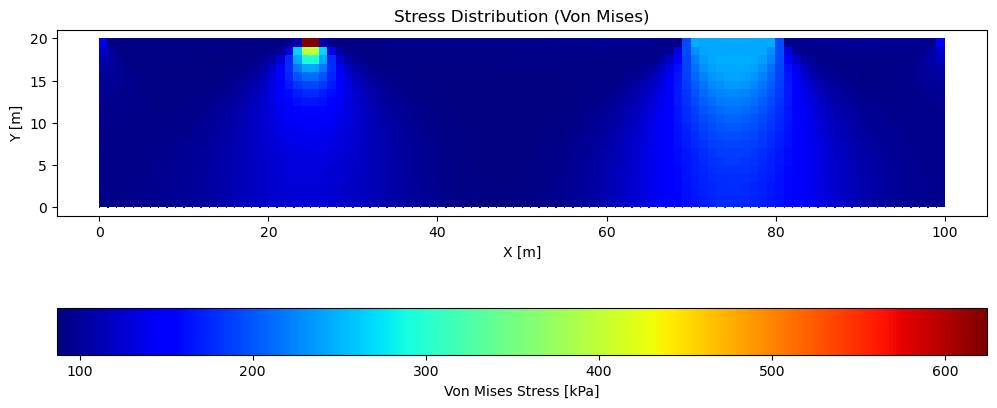

In [21]:
# Plot stress distribution
plot_stress_distribution(nodes, elements, von_mises_stress)